#### By: Peyman Shahidi
#### Created: Oct 9, 2025
#### Last Edit: Oct 16, 2025

<br>

In [51]:
#Python
import getpass
import numpy as np
import pandas as pd
from collections import defaultdict
import itertools
import random 

## formatting number to appear comma separated and with two digits after decimal: e.g, 1000 shown as 1,000.00
pd.set_option('float_format', "{:,.2f}".format)

import matplotlib.pyplot as plt
#%matplotlib inline
#from matplotlib.legend import Legend

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', 200)

In [52]:
main_folder_path = ".."
input_data_path = f"{main_folder_path}/data"
output_data_path = f'{input_data_path}/computed_objects'
output_plot_path = f"{main_folder_path}/writeup/plots"

In [53]:
# Create directories if they don't exist
import os

for path in [output_data_path, output_plot_path]:
    if not os.path.exists(path):
        os.makedirs(path)

In [54]:
# Read O*NET data
ONET = pd.read_csv(f'{input_data_path}/computed_objects/ONET_cleaned_tasks.csv')

# Remove apostrophes for consistency
ONET = ONET.applymap(lambda x: x.replace("'", "") if isinstance(x, str) else x)

# Drop DWA columns
ONET = ONET.drop(columns=['DWA ID', 'DWA Title'])

# # Drop original Task ID and Task Title columns
# ONET = ONET.drop(columns=['Task ID', 'Task Title'])
# # Rename DWA ID and DWA Title to Task ID and Task Title
# ONET = ONET.rename(columns={'DWA ID': 'Task ID', 'DWA Title': 'Task Title'})

# Remove duplicate rows based on Occupation Title and new Task ID
rows_before = len(ONET)
print(f"Number of rows before removing duplicates: {rows_before:,}")
ONET = ONET.drop_duplicates(subset=['Occupation Title', 'Task ID']).reset_index(drop=True)
rows_after = len(ONET)
print(f"Number of rows after removing duplicates: {rows_after:,}")
print(f"Duplicates removed: {rows_before - rows_after}")

# Print length of dataset
print(f"Number of rows in ONET dataset: {len(ONET):,}")

ONET.head(5)

Number of rows before removing duplicates: 22,310
Number of rows after removing duplicates: 17,953
Duplicates removed: 4357
Number of rows in ONET dataset: 17,953


,O*NET-SOC Code,Occupation Title,Task ID,Task Title,Task Type,Job Zone,Task_Time_Percentage,Hourly_Mean_Wage,Hourly_P10_Wage,Hourly_P25_Wage,...,Relevance,Base_SOC_Code,Major_Group_Code,Major_Group_Title,Minor_Group_Code,Minor_Group_Title,Broad_Occupation_Code,Broad_Occupation_Title,Detailed_Occupation_Code,Detailed_Occupation_Title
0,11-1011.00,Chief Executives,8823,Direct or coordinate an organizations financia...,Core,5,9.62,124.47,38.46,62.90,...,94.19,11-1011,11-0000,Management Occupations,11-1000,Top Executives,11-1010,Chief Executives,11-1011,Chief Executives
1,11-1011.00,Chief Executives,8824,"Confer with board members, organization offici...",Core,5,9.49,124.47,38.46,62.90,...,98.79,11-1011,11-0000,Management Occupations,11-1000,Top Executives,11-1010,Chief Executives,11-1011,Chief Executives
2,11-1011.00,Chief Executives,8825,Analyze operations to evaluate performance of ...,Core,5,9.22,124.47,38.46,62.90,...,100.00,11-1011,11-0000,Management Occupations,11-1000,Top Executives,11-1010,Chief Executives,11-1011,Chief Executives
3,11-1011.00,Chief Executives,8826,"Direct, plan, or implement policies, objective...",Core,5,10.26,124.47,38.46,62.90,...,95.84,11-1011,11-0000,Management Occupations,11-1000,Top Executives,11-1010,Chief Executives,11-1011,Chief Executives
4,11-1011.00,Chief Executives,8827,"Prepare budgets for approval, including those ...",Core,5,1.46,124.47,38.46,62.90,...,90.47,11-1011,11-0000,Management Occupations,11-1000,Top Executives,11-1010,Chief Executives,11-1011,Chief Executives


In [55]:
# Drop rows with missing wage values and report the impact
print("Removing occupations with missing wage data:")
print("=" * 50)

# Check missing wages before filtering
missing_wages_before = ONET['Hourly_Mean_Wage'].isnull().sum()
total_rows_before = len(ONET)
unique_occupations_before = len(ONET['O*NET-SOC Code'].unique())

print(f"Before filtering:")
print(f"Total rows: {total_rows_before:,}")
print(f"Unique occupations: {unique_occupations_before:,}")
print(f"Missing wage values: {missing_wages_before:,}")
print(f"Percentage missing: {(missing_wages_before / total_rows_before) * 100:.2f}%")

# Drop rows with missing wage values
ONET = ONET.dropna(subset=['Hourly_Mean_Wage'])

# Filter to keep only "Core" task types
rows_after_wage_filter = len(ONET)
print(f"\nAfter wage filtering: {rows_after_wage_filter:,} rows")

print(f"Task Type distribution before filtering:")
print(ONET['Task Type'].value_counts())

ONET = ONET[ONET['Task Type'] == 'Core']

# Report after all filtering
total_rows_after = len(ONET)
print(f"\nAfter filtering (wage + Core tasks only):")
print(f"Total rows: {total_rows_after:,}")
print(f"Rows removed: {total_rows_before - total_rows_after:,}")
print(f"Percentage of data retained: {(total_rows_after / total_rows_before) * 100:.2f}%")

# Check how many unique occupations were affected
unique_occupations_after = len(ONET['O*NET-SOC Code'].unique())
occupations_lost = unique_occupations_before - unique_occupations_after
print(f"\nUnique occupations after filtering: {unique_occupations_after:,}")
print(f"Occupations lost due to missing wages: {occupations_lost:,}")

Removing occupations with missing wage data:
Before filtering:
Total rows: 17,953
Unique occupations: 873
Missing wage values: 434
Percentage missing: 2.42%

After wage filtering: 17,519 rows
Task Type distribution before filtering:
Task Type
Core            12901
Supplemental     4618
Name: count, dtype: int64

After filtering (wage + Core tasks only):
Total rows: 12,901
Rows removed: 5,052
Percentage of data retained: 71.86%

Unique occupations after filtering: 849
Occupations lost due to missing wages: 24


In [56]:
# # Drop original Task ID and Task Title columns
# ONET = ONET.drop(columns=['Task ID', 'Task Title'])
# # Rename DWA ID and DWA Title to Task ID and Task Title
# ONET = ONET.rename(columns={'DWA ID': 'Task ID', 'DWA Title': 'Task Title'})

In [57]:
# Create dataset with selected columns and unique task count
selected_columns = ['O*NET-SOC Code', 'Occupation Title', 'Hourly_Mean_Wage', 'Job Zone', 'Task ID']
onet_filtered = ONET[selected_columns].copy()

# Add unique task count per occupation
task_counts = onet_filtered.groupby('O*NET-SOC Code')['Task ID'].nunique().reset_index()
task_counts.columns = ['O*NET-SOC Code', 'Unique_Task_Count']
occupation_df = onet_filtered.merge(task_counts, on='O*NET-SOC Code', how='left')
occupation_df = occupation_df.drop(columns=['Task ID'])

# Create occupation dataframe
occupation_summary = occupation_df.drop_duplicates(subset=['O*NET-SOC Code', 'Occupation Title', 'Hourly_Mean_Wage', 'Job Zone', 'Unique_Task_Count']).reset_index()
occupation_summary.head()

,index,O*NET-SOC Code,Occupation Title,Hourly_Mean_Wage,Job Zone,Unique_Task_Count
0,0,11-1011.00,Chief Executives,124.47,5,19
1,19,11-1011.03,Chief Sustainability Officers,124.47,5,18
2,37,11-1021.00,General and Operations Managers,62.18,4,9
3,46,11-2011.00,Advertising and Promotions Managers,73.38,4,13
4,59,11-2021.00,Marketing Managers,80.00,4,12


### Plot wages (different percentiles and mean) against job zones and number of unique tasks within occupation

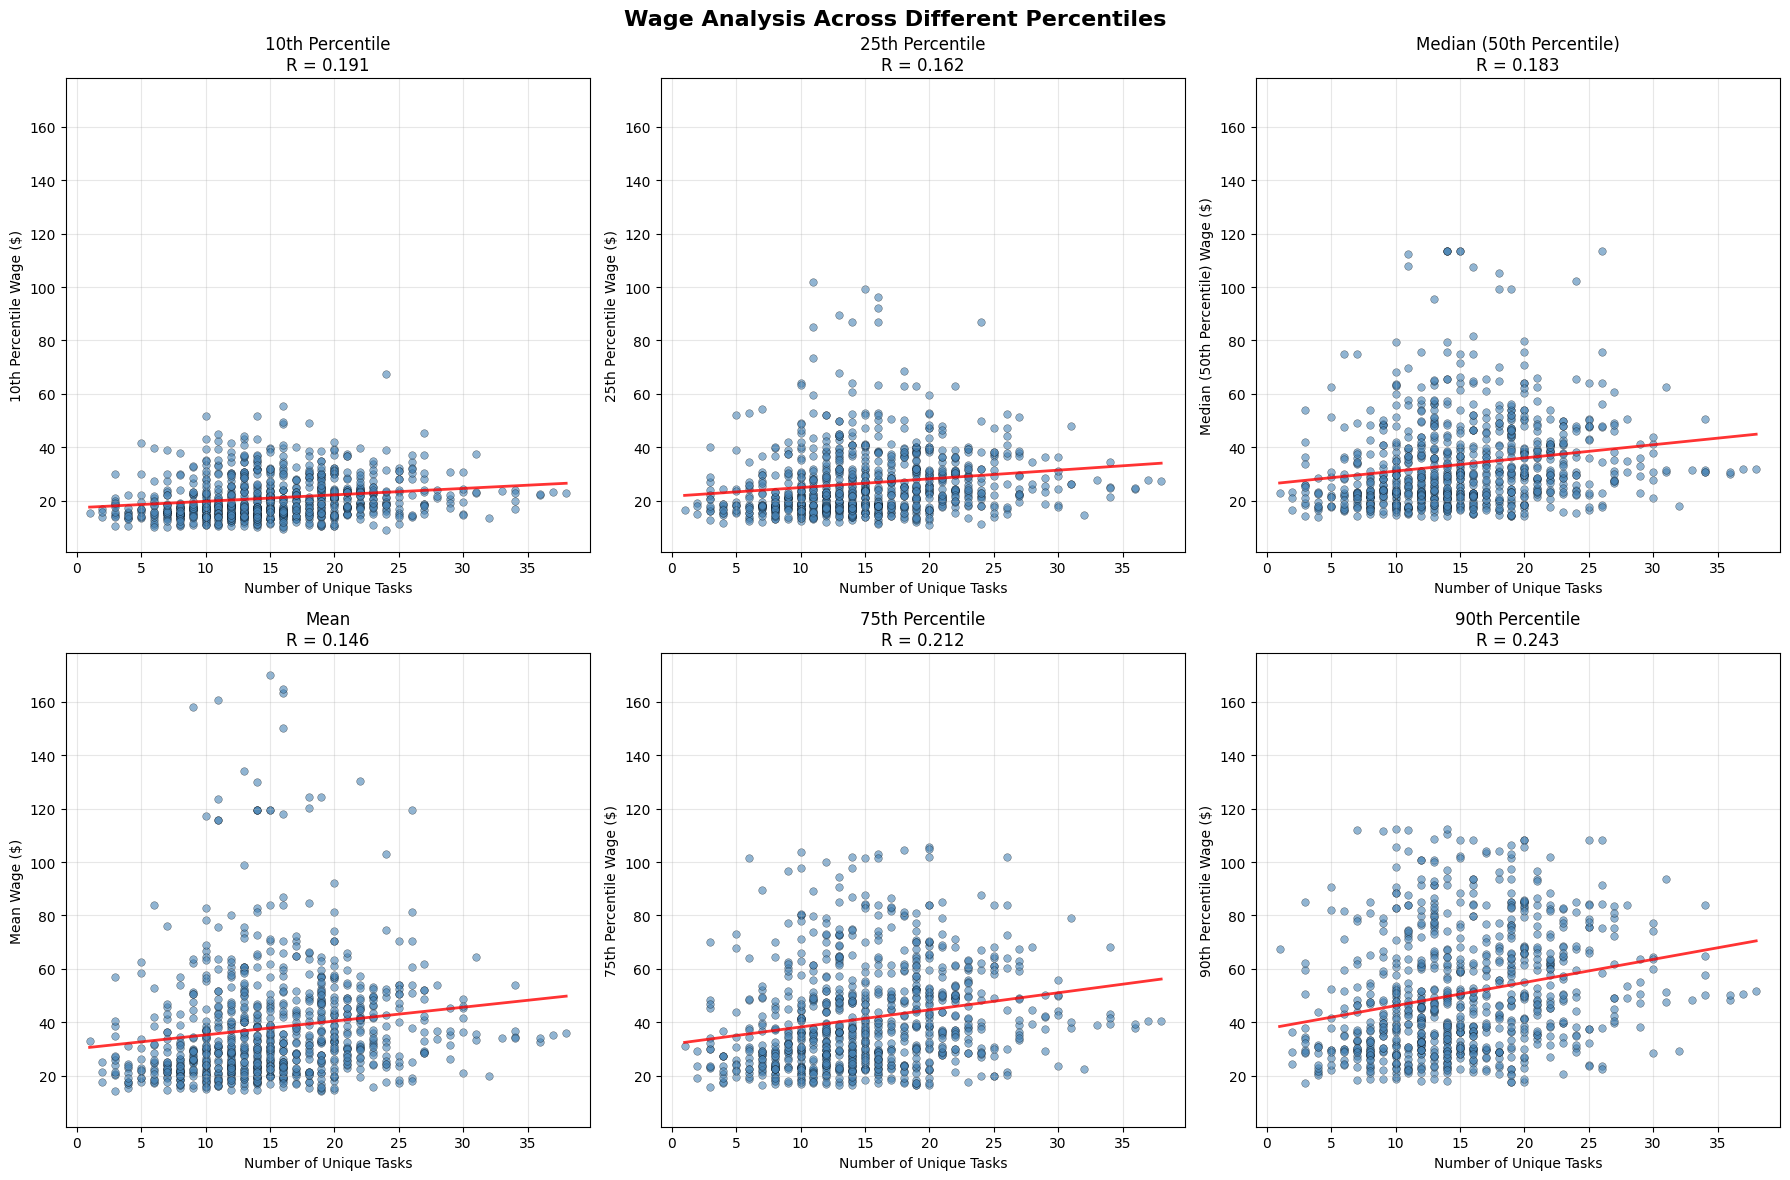

In [58]:
# Analysis using different wage percentiles instead of mean wage
wage_columns = [col for col in ONET.columns if 'Hourly' in col and 'Wage' in col]

# Create occupation summary with all wage percentiles
selected_columns = ['O*NET-SOC Code', 'Occupation Title', 'Job Zone', 'Task ID'] + wage_columns
onet_wage_filtered = ONET[selected_columns].copy()

# Add unique task count per occupation
task_counts = onet_wage_filtered.groupby('O*NET-SOC Code')['Task ID'].nunique().reset_index()
task_counts.columns = ['O*NET-SOC Code', 'Unique_Task_Count']
occupation_wage_df = onet_wage_filtered.merge(task_counts, on='O*NET-SOC Code', how='left')
occupation_wage_df = occupation_wage_df.drop(columns=['Task ID'])

# Create occupation summary with all wage percentiles
occupation_wage_summary = occupation_wage_df.drop_duplicates(
    subset=['O*NET-SOC Code', 'Occupation Title', 'Job Zone', 'Unique_Task_Count'] + wage_columns
).reset_index(drop=True)

# Define wage percentiles to analyze
wage_percentiles = {
    'Hourly_P10_Wage': '10th Percentile',
    'Hourly_P25_Wage': '25th Percentile', 
    'Hourly_Median_Wage': 'Median (50th Percentile)',
    'Hourly_Mean_Wage': 'Mean',
    'Hourly_P75_Wage': '75th Percentile',
    'Hourly_P90_Wage': '90th Percentile'
}

# Filter for available wage columns
available_percentiles = {col: desc for col, desc in wage_percentiles.items() if col in occupation_wage_summary.columns}

# Calculate global y-axis limits for consistent scaling across all wage plots
all_wage_values = []
for wage_col in available_percentiles.keys():
    clean_data = occupation_wage_summary[wage_col].dropna()
    if len(clean_data) > 0:
        all_wage_values.extend(clean_data.values)

if all_wage_values:
    global_y_min = min(all_wage_values)
    global_y_max = max(all_wage_values)
    # Add some padding for better visualization
    y_padding = (global_y_max - global_y_min) * 0.05
    global_y_min = max(0, global_y_min - y_padding)  # Don't go below 0 for wages
    global_y_max = global_y_max + y_padding
else:
    global_y_min, global_y_max = 0, 100  # Default values

# Create comprehensive analysis plots
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Wage Analysis Across Different Percentiles', fontsize=16, fontweight='bold')

for idx, (wage_col, wage_desc) in enumerate(available_percentiles.items()):
    row = idx // 3
    col = idx % 3
    ax = axes[row, col]
    
    # Remove missing values for this wage column
    clean_data = occupation_wage_summary[['Unique_Task_Count', 'Job Zone', wage_col]].dropna()
    
    if len(clean_data) == 0:
        ax.text(0.5, 0.5, f'No data available\nfor {wage_desc}', 
                ha='center', va='center', transform=ax.transAxes)
        ax.set_title(f'{wage_desc}\n(No Data)')
        ax.set_ylim(global_y_min, global_y_max)
        continue
    
    # Scatter plot: Tasks vs Wage
    ax.scatter(clean_data['Unique_Task_Count'], clean_data[wage_col], 
               alpha=0.6, s=30, color='steelblue', edgecolor='black', linewidth=0.3)
    
    # Calculate correlation and add trend line
    correlation = clean_data['Unique_Task_Count'].corr(clean_data[wage_col])
    
    if not pd.isna(correlation):
        z = np.polyfit(clean_data['Unique_Task_Count'], clean_data[wage_col], 1)
        p = np.poly1d(z)
        x_line = np.linspace(clean_data['Unique_Task_Count'].min(), clean_data['Unique_Task_Count'].max(), 100)
        ax.plot(x_line, p(x_line), 'r-', alpha=0.8, linewidth=2)
    
    ax.set_xlabel('Number of Unique Tasks')
    ax.set_ylabel(f'{wage_desc} Wage ($)')
    ax.set_title(f'{wage_desc}\nR = {correlation:.3f}' if not pd.isna(correlation) else f'{wage_desc}\n(No correlation)')
    ax.set_ylim(global_y_min, global_y_max)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
# Make sure output directory exists
os.makedirs(f'{output_plot_path}/wage_vs_taskCount', exist_ok=True)
plt.savefig(f'{output_plot_path}/wage_vs_taskCount/wage_vs_taskCount.png', dpi=300)
plt.show()

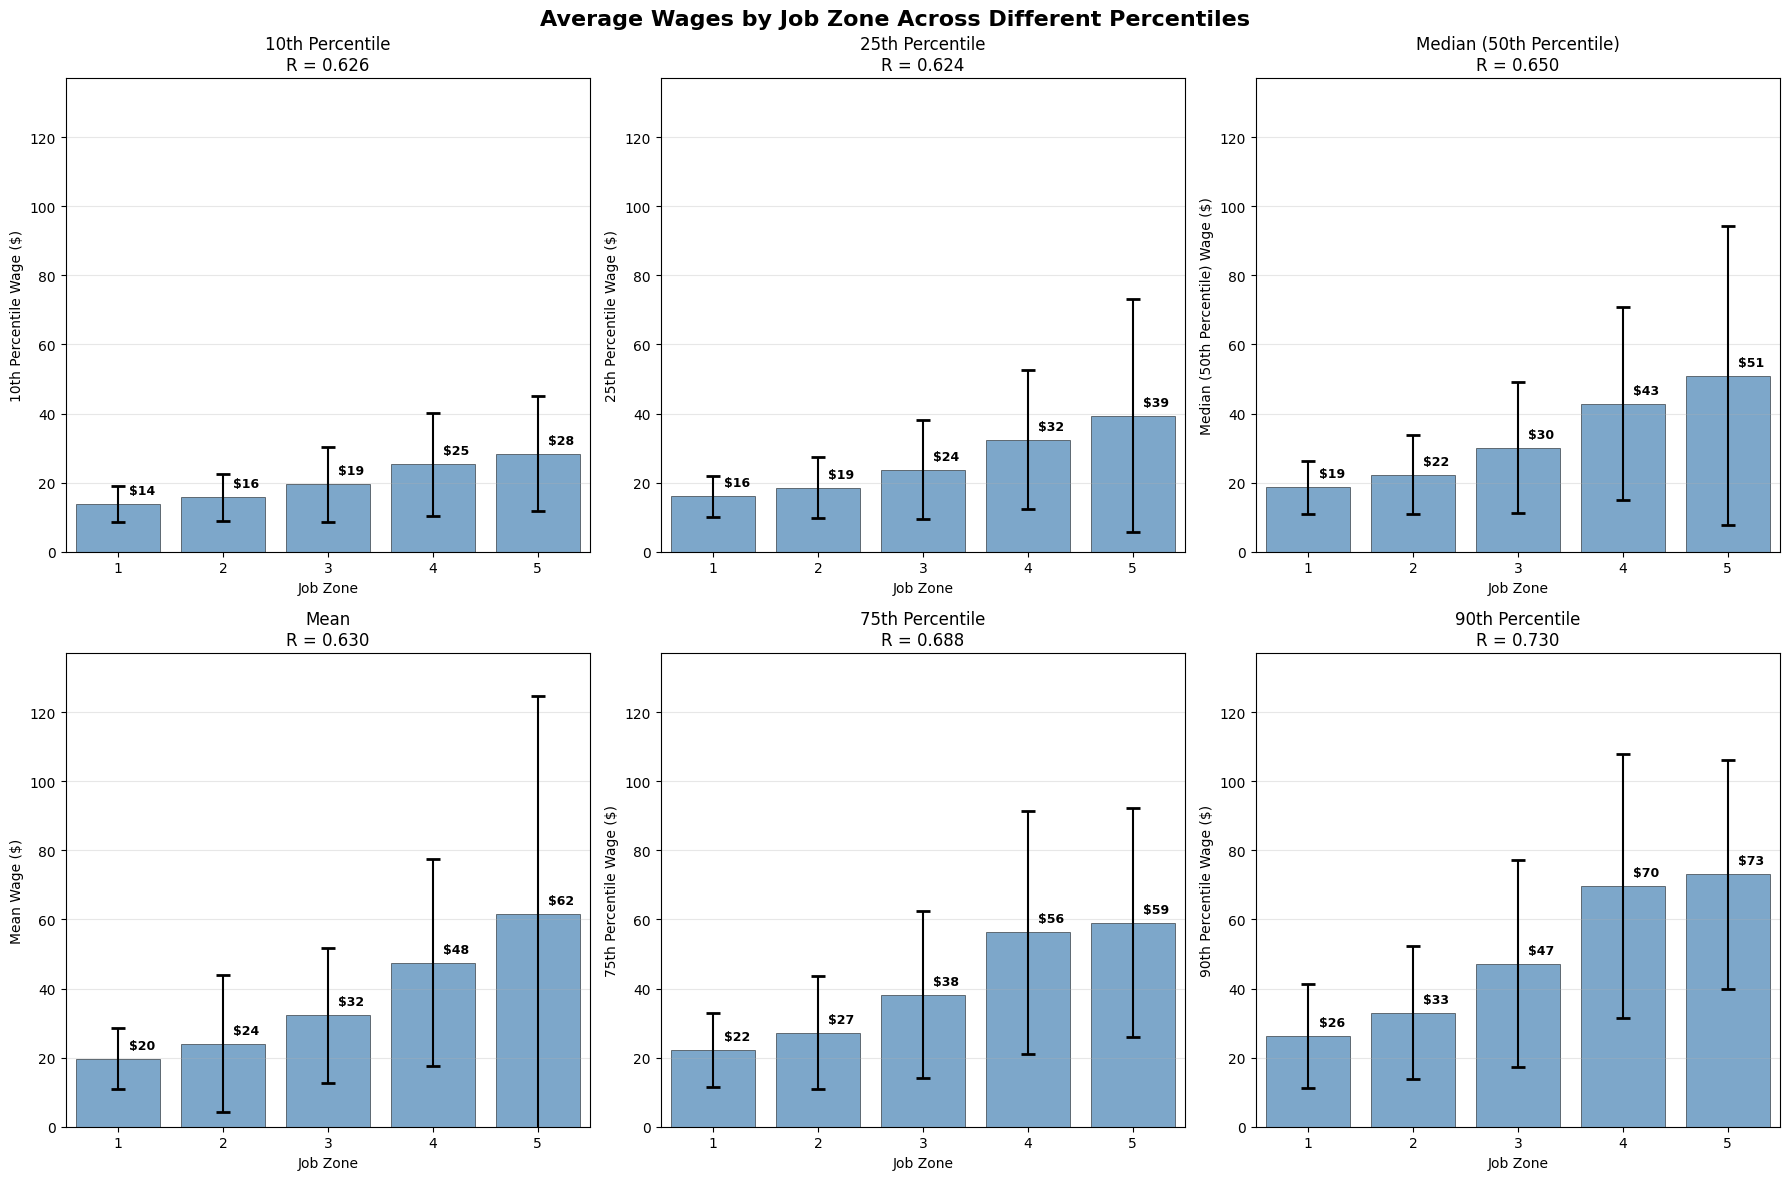

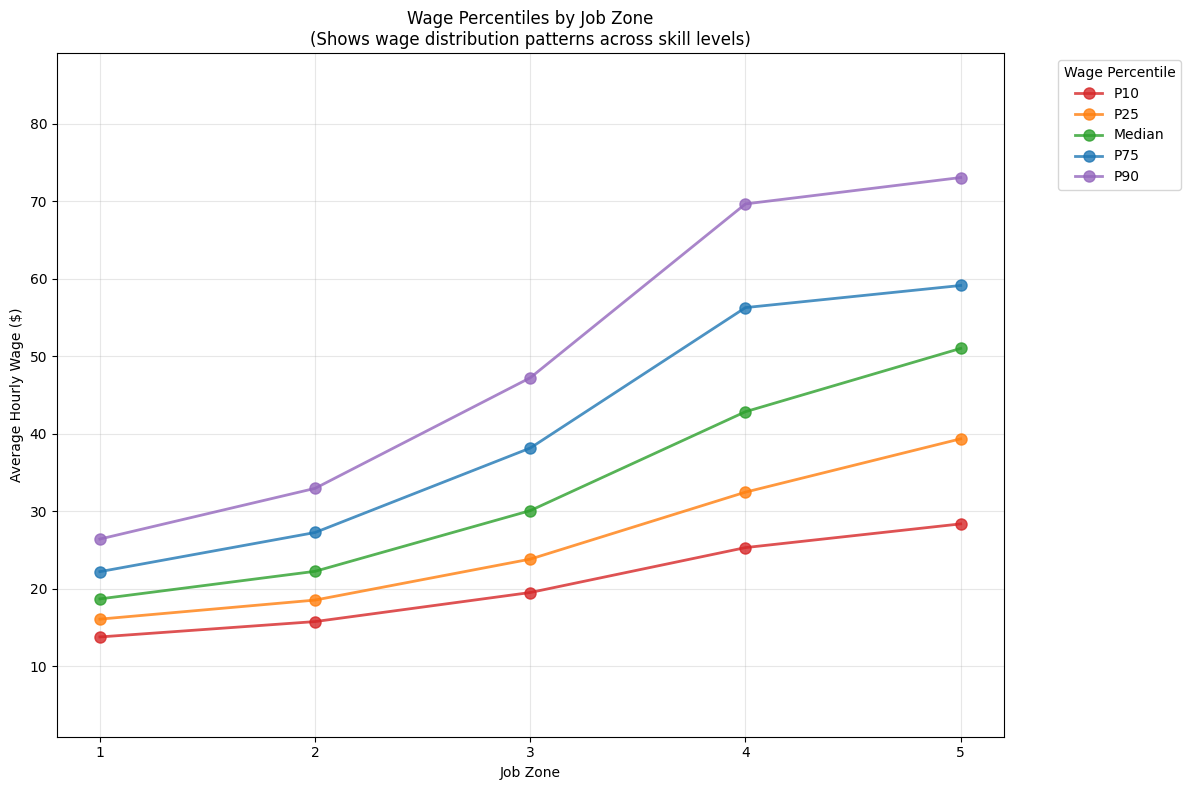

In [59]:
# Create wage by job zone plots for different percentiles
available_percentiles = {
    'Hourly_P10_Wage': '10th Percentile',
    'Hourly_P25_Wage': '25th Percentile', 
    'Hourly_Median_Wage': 'Median (50th Percentile)',
    'Hourly_Mean_Wage': 'Mean',
    'Hourly_P75_Wage': '75th Percentile',
    'Hourly_P90_Wage': '90th Percentile'
}

# Filter for existing columns in the dataset
available_percentiles = {col: desc for col, desc in available_percentiles.items() 
                        if col in occupation_wage_summary.columns}

# Calculate y-axis limits for bar charts (including error bars)
all_bar_values = []
for wage_col in available_percentiles.keys():
    clean_data = occupation_wage_summary[['Job Zone', wage_col]].dropna()
    if len(clean_data) > 0:
        job_zones = sorted(clean_data['Job Zone'].unique())
        for zone in job_zones:
            zone_data = clean_data[clean_data['Job Zone'] == zone]
            zone_mean = zone_data[wage_col].mean()
            zone_std = zone_data[wage_col].std()
            # Include the maximum possible value with error bar
            all_bar_values.append(zone_mean + (1.96 * zone_std if not pd.isna(zone_std) else 0))
            all_bar_values.append(zone_mean)

if all_bar_values:
    bar_y_max = max(all_bar_values)
    bar_y_min = 0  # Start bars from 0
    # Add padding for labels above bars
    bar_y_max = bar_y_max * 1.1
else:
    bar_y_min, bar_y_max = 0, 100

# Create subplots for wage by job zone analysis
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Average Wages by Job Zone Across Different Percentiles', fontsize=16, fontweight='bold')

for idx, (wage_col, wage_desc) in enumerate(available_percentiles.items()):
    row = idx // 3
    col = idx % 3
    ax = axes[row, col]
    
    # Calculate mean and standard deviation for each job zone for this wage percentile
    clean_data = occupation_wage_summary[['Job Zone', wage_col]].dropna()
    
    if len(clean_data) == 0:
        ax.text(0.5, 0.5, f'No data available\nfor {wage_desc}', 
                ha='center', va='center', transform=ax.transAxes)
        ax.set_title(f'{wage_desc}\n(No Data)')
        ax.set_ylim(bar_y_min, bar_y_max)
        continue
    
    job_zones = sorted(clean_data['Job Zone'].unique())
    zone_means = []
    zone_stds = []
    
    for zone in job_zones:
        zone_data = clean_data[clean_data['Job Zone'] == zone]
        zone_means.append(zone_data[wage_col].mean())
        zone_stds.append(zone_data[wage_col].std())
    
    # Create bar plot with error bars (1.96 * std for 95% confidence interval)
    error_bars = [1.96 * std if not pd.isna(std) else 0 for std in zone_stds]
    
    bars = ax.bar(job_zones, zone_means, alpha=0.7, color='steelblue', 
                  edgecolor='black', linewidth=0.5)
    ax.errorbar(job_zones, zone_means, yerr=error_bars, fmt='none', 
               color='black', capsize=5, capthick=2)
    
    # Add value labels on top of bars
    for i, (zone, mean) in enumerate(zip(job_zones, zone_means)):
        ax.text(zone + 0.1, mean + 2, f'${mean:.0f}', 
               ha='left', va='bottom', fontweight='bold', fontsize=9)
    
    # Calculate correlation between job zone and this wage percentile
    correlation = clean_data['Job Zone'].corr(clean_data[wage_col])
    
    ax.set_xlabel('Job Zone')
    ax.set_ylabel(f'{wage_desc} Wage ($)')
    ax.set_title(f'{wage_desc}\nR = {correlation:.3f}' if not pd.isna(correlation) else f'{wage_desc}\n(No correlation)')
    ax.set_ylim(bar_y_min, bar_y_max)
    ax.grid(True, alpha=0.3, axis='y')
    
    # Set consistent x-axis
    ax.set_xlim(0.5, 5.5)
    ax.set_xticks(job_zones)

plt.tight_layout()
plt.savefig(f'{output_plot_path}/wage_vs_taskCount/wage_vs_jobZone1.png', dpi=300)
plt.show()

# Create a summary comparison plot showing wage ranges by job zone
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

# Select key percentiles for range visualization
key_percentiles = ['Hourly_P10_Wage', 'Hourly_P25_Wage', 'Hourly_Median_Wage', 
                   'Hourly_P75_Wage', 'Hourly_P90_Wage']
existing_key_percentiles = [col for col in key_percentiles if col in occupation_wage_summary.columns]

# Create wage ranges for each job zone
job_zones = sorted(occupation_wage_summary['Job Zone'].unique())
x_positions = np.arange(len(job_zones))

colors = ['#d62728', '#ff7f0e', '#2ca02c', '#1f77b4', '#9467bd']

for i, percentile in enumerate(existing_key_percentiles):
    zone_values = []
    for zone in job_zones:
        zone_data = occupation_wage_summary[occupation_wage_summary['Job Zone'] == zone]
        zone_mean = zone_data[percentile].mean()
        zone_values.append(zone_mean)
    
    percentile_label = {
        'Hourly_P10_Wage': 'P10',
        'Hourly_P25_Wage': 'P25',
        'Hourly_Median_Wage': 'Median',
        'Hourly_P75_Wage': 'P75',
        'Hourly_P90_Wage': 'P90'
    }
    
    ax.plot(x_positions, zone_values, 'o-', color=colors[i % len(colors)], 
           linewidth=2, markersize=8, label=percentile_label.get(percentile, percentile),
           alpha=0.8)

ax.set_xlabel('Job Zone')
ax.set_ylabel('Average Hourly Wage ($)')
ax.set_title('Wage Percentiles by Job Zone\n(Shows wage distribution patterns across skill levels)')
ax.set_xticks(x_positions)
ax.set_xticklabels(job_zones)
ax.set_ylim(global_y_min, global_y_max/2)  # Use the same global scale
ax.legend(title='Wage Percentile', bbox_to_anchor=(1.05, 1), loc='upper left')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f'{output_plot_path}/wage_vs_taskCount/wage_vs_jobZone2.png', dpi=300)
plt.show()

### Repeat the same analysis but with reshuffled data

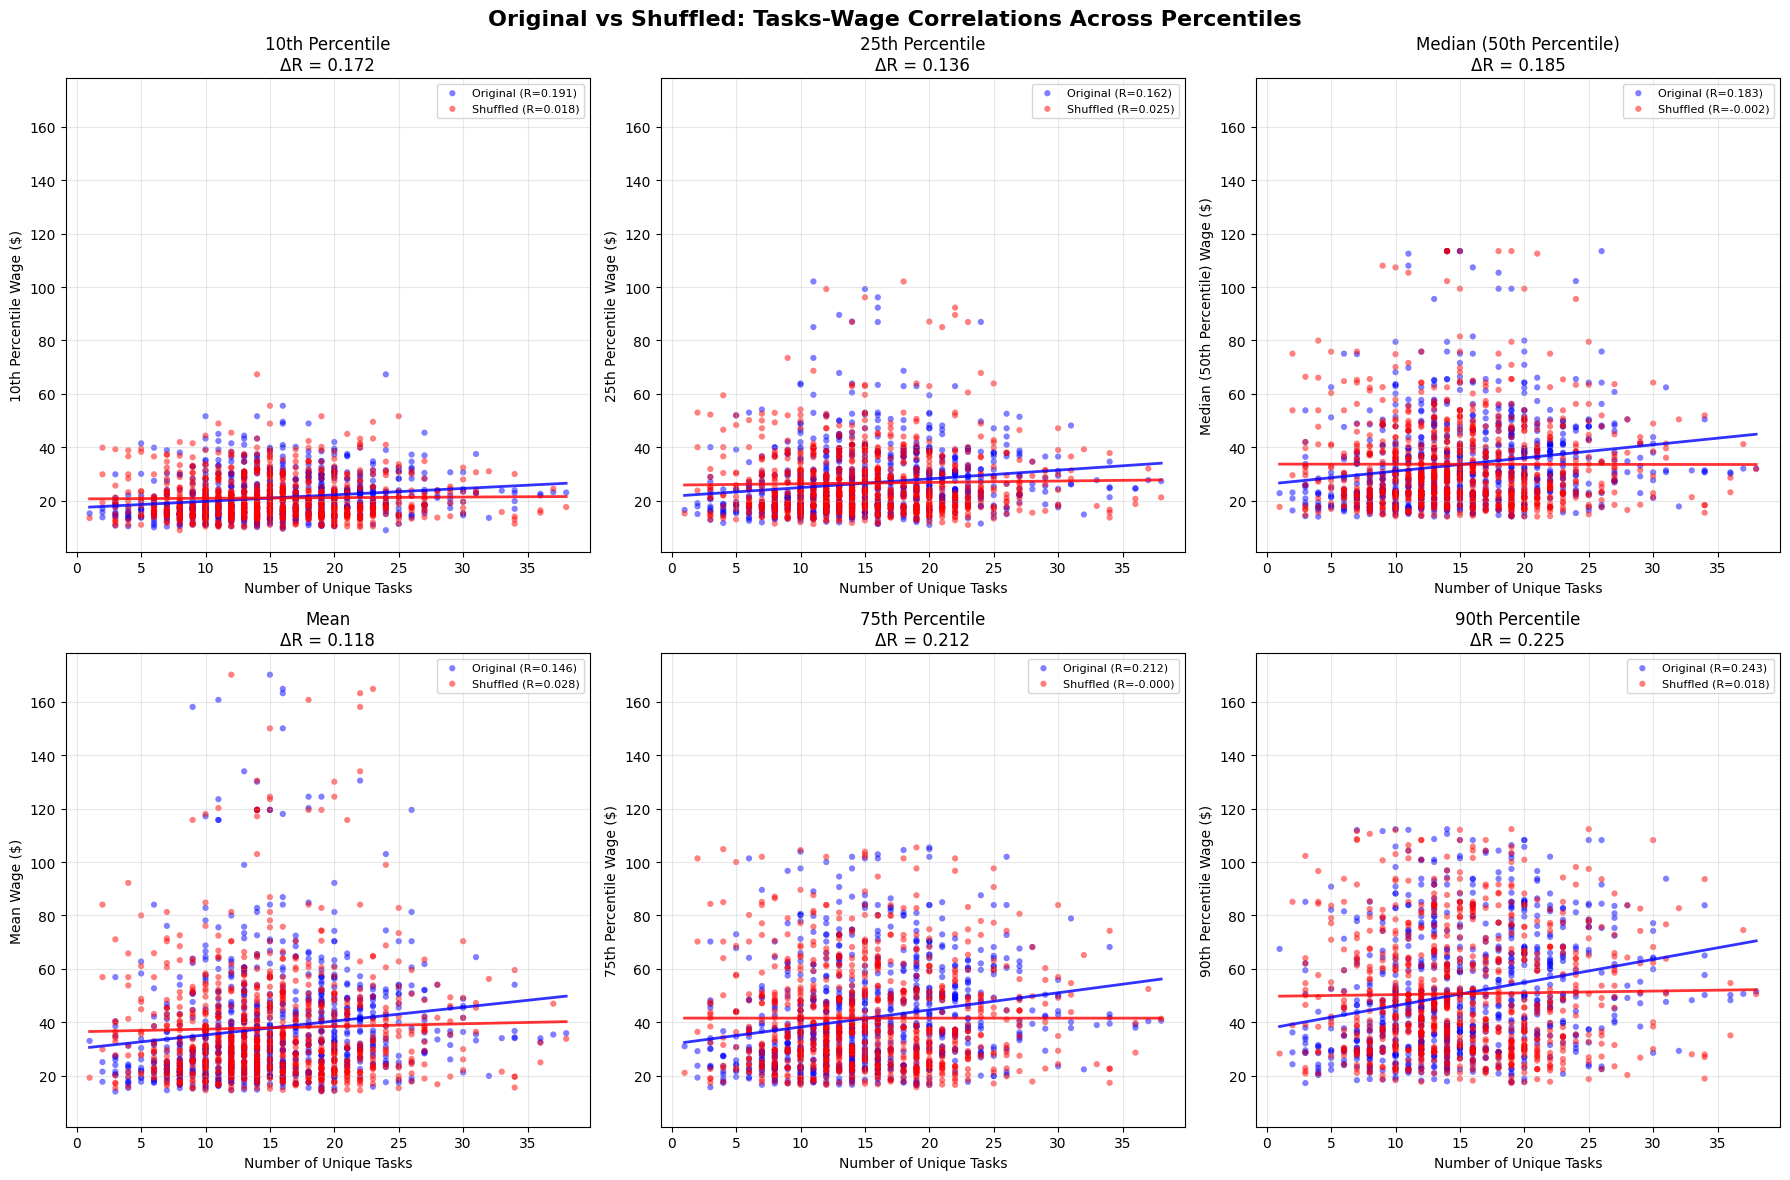

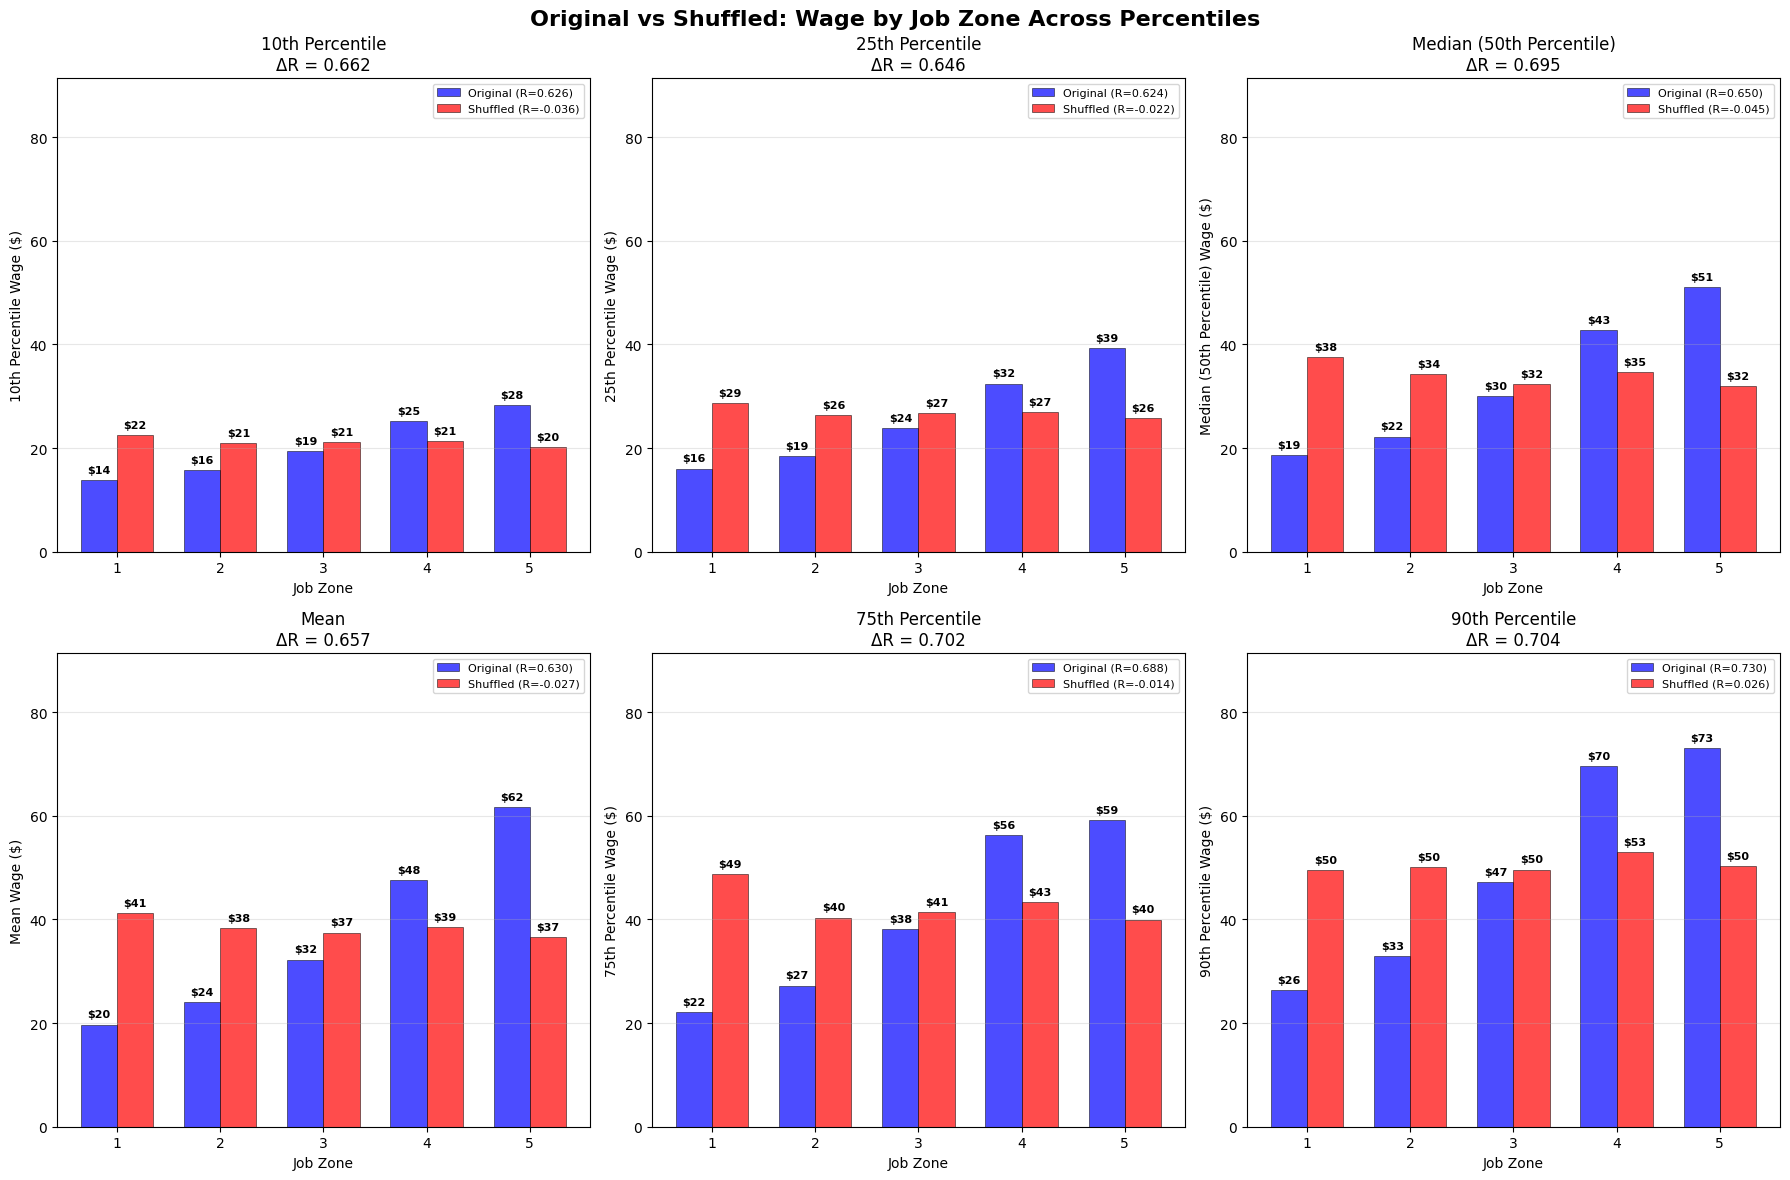

In [60]:
# Shuffled analysis using different wage percentiles
import numpy as np
np.random.seed(42)  # For reproducibility

# Get available wage columns from the original occupation_wage_summary
wage_columns = [col for col in ONET.columns if 'Hourly' in col and 'Wage' in col]
available_percentiles = {
    'Hourly_P10_Wage': '10th Percentile',
    'Hourly_P25_Wage': '25th Percentile', 
    'Hourly_Median_Wage': 'Median (50th Percentile)',
    'Hourly_Mean_Wage': 'Mean',
    'Hourly_P75_Wage': '75th Percentile',
    'Hourly_P90_Wage': '90th Percentile'
}

# Filter for existing columns in the dataset
available_percentiles = {col: desc for col, desc in available_percentiles.items() 
                        if col in occupation_wage_summary.columns}

# Create shuffled version where we permute the ENTIRE wage distributions
shuffled_wage_data = occupation_wage_summary.copy()

# Get all wage columns
wage_cols = [col for col in occupation_wage_summary.columns if 'Hourly' in col and 'Wage' in col]

# Create indices for shuffling
n_occupations = len(occupation_wage_summary)
shuffled_indices = np.random.permutation(n_occupations)

# Shuffle all wage columns together using the same permutation
for wage_col in wage_cols:
    shuffled_wage_data[wage_col] = occupation_wage_summary[wage_col].iloc[shuffled_indices].values

# Create comparison visualization
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Original vs Shuffled: Tasks-Wage Correlations Across Percentiles', fontsize=16, fontweight='bold')

for idx, (wage_col, wage_desc) in enumerate(available_percentiles.items()):
    row = idx // 3
    col = idx % 3
    ax = axes[row, col]
    
    # Get clean data for both original and shuffled
    clean_original = occupation_wage_summary[['Unique_Task_Count', wage_col]].dropna()
    clean_shuffled = shuffled_wage_data[['Unique_Task_Count', wage_col]].dropna()
    
    if len(clean_original) == 0 or len(clean_shuffled) == 0:
        ax.text(0.5, 0.5, f'No data available\nfor {wage_desc}', 
                ha='center', va='center', transform=ax.transAxes)
        ax.set_title(f'{wage_desc}\n(No Data)')
        ax.set_ylim(global_y_min, global_y_max)
        continue
    
    # Calculate correlations
    original_corr = clean_original['Unique_Task_Count'].corr(clean_original[wage_col])
    shuffled_corr = clean_shuffled['Unique_Task_Count'].corr(clean_shuffled[wage_col])
    
    # Plot both original and shuffled data
    ax.scatter(clean_original['Unique_Task_Count'], clean_original[wage_col], 
               alpha=0.5, s=20, color='blue', label=f'Original (R={original_corr:.3f})', edgecolor='none')
    ax.scatter(clean_shuffled['Unique_Task_Count'], clean_shuffled[wage_col], 
               alpha=0.5, s=20, color='red', label=f'Shuffled (R={shuffled_corr:.3f})', edgecolor='none')
    
    # Add trend lines
    if not pd.isna(original_corr):
        z_orig = np.polyfit(clean_original['Unique_Task_Count'], clean_original[wage_col], 1)
        p_orig = np.poly1d(z_orig)
        x_line_orig = np.linspace(clean_original['Unique_Task_Count'].min(), clean_original['Unique_Task_Count'].max(), 100)
        ax.plot(x_line_orig, p_orig(x_line_orig), 'b-', alpha=0.8, linewidth=2)
    
    if not pd.isna(shuffled_corr):
        z_shuf = np.polyfit(clean_shuffled['Unique_Task_Count'], clean_shuffled[wage_col], 1)
        p_shuf = np.poly1d(z_shuf)
        x_line_shuf = np.linspace(clean_shuffled['Unique_Task_Count'].min(), clean_shuffled['Unique_Task_Count'].max(), 100)
        ax.plot(x_line_shuf, p_shuf(x_line_shuf), 'r-', alpha=0.8, linewidth=2)
    
    ax.set_xlabel('Number of Unique Tasks')
    ax.set_ylabel(f'{wage_desc} Wage ($)')
    ax.set_title(f'{wage_desc}\nΔR = {original_corr - shuffled_corr:.3f}')
    ax.set_ylim(global_y_min, global_y_max)
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=8)

plt.tight_layout()
# Make sure output directory exists
os.makedirs(f'{output_plot_path}/wage_vs_taskCount/sanityCheck', exist_ok=True)
plt.savefig(f'{output_plot_path}/wage_vs_taskCount/sanityCheck/wage_vs_taskCount_sanity.png', dpi=300)
plt.show()

# Use the same shuffled dataset where entire wage distributions were shuffled
shuffled_zone_data = shuffled_wage_data.copy()

# Create wage by job zone comparison plots
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Original vs Shuffled: Wage by Job Zone Across Percentiles', fontsize=16, fontweight='bold')

for idx, (wage_col, wage_desc) in enumerate(available_percentiles.items()):
    row = idx // 3
    col = idx % 3
    ax = axes[row, col]
    
    # Calculate job zone means for original data
    clean_original = occupation_wage_summary[['Job Zone', wage_col]].dropna()
    # Calculate job zone means for shuffled data (job zones shuffled, wages unchanged)
    clean_shuffled = shuffled_zone_data[['Job Zone', wage_col]].dropna()
    
    if len(clean_original) == 0 or len(clean_shuffled) == 0:
        ax.text(0.5, 0.5, f'No data available\nfor {wage_desc}', 
                ha='center', va='center', transform=ax.transAxes)
        ax.set_title(f'{wage_desc}\n(No Data)')
        ax.set_ylim(bar_y_min, bar_y_max)
        continue
    
    job_zones = sorted(clean_original['Job Zone'].unique())
    
    # Original job zone means
    orig_zone_means = []
    shuf_zone_means = []
    
    for zone in job_zones:
        orig_zone_data = clean_original[clean_original['Job Zone'] == zone]
        shuf_zone_data = clean_shuffled[clean_shuffled['Job Zone'] == zone]
        orig_zone_means.append(orig_zone_data[wage_col].mean())
        shuf_zone_means.append(shuf_zone_data[wage_col].mean())
    
    # Calculate correlations
    original_zone_corr = clean_original['Job Zone'].corr(clean_original[wage_col])
    shuffled_zone_corr = clean_shuffled['Job Zone'].corr(clean_shuffled[wage_col])
    
    # Create side-by-side bars
    x_positions = np.arange(len(job_zones))
    width = 0.35
    
    bars1 = ax.bar(x_positions - width/2, orig_zone_means, width, 
                   alpha=0.7, color='blue', label=f'Original (R={original_zone_corr:.3f})',
                   edgecolor='black', linewidth=0.5)
    bars2 = ax.bar(x_positions + width/2, shuf_zone_means, width,
                   alpha=0.7, color='red', label=f'Shuffled (R={shuffled_zone_corr:.3f})',
                   edgecolor='black', linewidth=0.5)
    
    # Add value labels on bars
    for i, (orig_mean, shuf_mean) in enumerate(zip(orig_zone_means, shuf_zone_means)):
        ax.text(i - width/2, orig_mean + 1, f'${orig_mean:.0f}', 
               ha='center', va='bottom', fontweight='bold', fontsize=8)
        ax.text(i + width/2, shuf_mean + 1, f'${shuf_mean:.0f}', 
               ha='center', va='bottom', fontweight='bold', fontsize=8)
    
    ax.set_xlabel('Job Zone')
    ax.set_ylabel(f'{wage_desc} Wage ($)')
    ax.set_title(f'{wage_desc}\nΔR = {original_zone_corr - shuffled_zone_corr:.3f}')
    ax.set_xticks(x_positions)
    ax.set_xticklabels(job_zones)
    ax.set_ylim(bar_y_min, bar_y_max/(1.5))
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(f'{output_plot_path}/wage_vs_taskCount/sanityCheck/wage_vs_jobZone_sanity.png', dpi=300)
plt.show()